In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import theano
from sklearn.metrics import mean_squared_error
from pymc3.ode import DifferentialEquation
from scipy.integrate import odeint
from random import seed
import scipy.optimize as opt
plt.style.use("seaborn-darkgrid")

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
import datetime
import pandas as pd
import plotly.express as px
px.defaults.height=600

In [3]:
Totales_Nacionales_Diarios = pd.read_csv("https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto5/TotalesNacionales.csv",index_col=0)

In [4]:
Total_poblacional = pd.read_csv("https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto1/Covid-19.csv",index_col=0)

Total_poblacional['Poblacion'].isna().sum()

16

In [5]:
len(Total_poblacional)-16

346

In [6]:
Total_poblacional=int(Total_poblacional['Poblacion'].sum())
Total_poblacional

19458310

In [7]:
df = Totales_Nacionales_Diarios.T

In [8]:
columnas_a = [
'Casos nuevos con sintomas'  
,'Casos totales'  
,'Casos recuperados'  
,'Fallecidos'  
,'Casos activos' 
,'Casos nuevos sin sintomas' 
,'Casos nuevos totales' 
,'Casos activos por FD' 
,'Casos activos por FIS' 
,'Casos recuperados por FIS' 
,'Casos recuperados por FD' 
,'Casos confirmados recuperados' 
,'Casos activos confirmados' 
,'Casos probables acumulados' 
,'Casos activos probables' 
,'Casos nuevos sin notificar' 
,'Casos confirmados por antigeno' 
,'Casos con sospecha de reinfeccion' 
,'Casos nuevos confirmados por antigeno' 
,'Fallecidos confirmados totales' 
,'Fallecidos sospechosos probables u otros totales' 
]

In [9]:
new = df[['Casos totales','Casos nuevos totales','Casos activos confirmados','Casos confirmados recuperados']].copy()
new=new/Total_poblacional
new.tail(10)

Fecha,Casos totales,Casos nuevos totales,Casos activos confirmados,Casos confirmados recuperados
2022-09-22,0.236121,0.000208,0.000504,0.232027
2022-09-23,0.236361,0.000234,0.000627,0.232137
2022-09-24,0.236583,0.000219,0.000749,0.232225
2022-09-25,0.236792,0.000201,0.000830,0.232345
2022-09-26,0.236935,0.000138,0.000834,0.232479
2022-09-27,0.237034,0.000096,0.000764,0.232646
2022-09-28,0.237240,0.000200,0.000736,0.232879
2022-09-29,0.237450,0.000205,0.000740,0.233074
2022-09-30,0.237652,0.000194,0.000761,0.233254
2022-10-01,0.237838,0.000175,0.000783,0.233408


In [10]:
new['Casos activos confirmados'].min()

0.00014955050053164947

In [11]:
new['Casos activos confirmados'].max()

0.0075933110326641936

In [12]:
Recuperados_diarios=new.diff()
Recuperados_diarios=Recuperados_diarios['Casos confirmados recuperados']
new['Recuperados diarios']=Recuperados_diarios

In [13]:
filtered_df=new.loc['2020-03-18':'2021-09-30']
filtered_df

Fecha,Casos totales,Casos nuevos totales,Casos activos confirmados,Casos confirmados recuperados,Recuperados diarios
2020-03-18,0.000012,0.000002,NaN,NaN,NaN
2020-03-19,0.000018,0.000005,NaN,NaN,NaN
2020-03-20,0.000022,0.000005,NaN,NaN,NaN
2020-03-21,0.000028,0.000005,NaN,NaN,NaN
2020-03-22,0.000032,0.000005,NaN,NaN,NaN
...,...,...,...,...,...
2021-09-26,0.084887,0.000040,0.000231,0.082585,0.000024
2021-09-27,0.084918,0.000033,0.000233,0.082612,0.000027
2021-09-28,0.084940,0.000023,0.000198,0.082668,0.000056
2021-09-29,0.084972,0.000027,0.000207,0.082690,0.000022


In [14]:
filtered_df_p1=new.loc['2020-07-01':'2020-10-31']
filtered_df_p2=new.loc['2020-11-01':'2021-02-28']
filtered_df_p3=new.loc['2021-03-01':'2021-06-30']
filtered_df_p4=new.loc['2021-07-01':'2021-10-31']
filtered_df_p5=new.loc['2021-11-01':'2022-02-28']
filtered_df_total=new.loc['2020-07-01':'2022-07-19']

In [15]:
fig = px.line(filtered_df_total, y=['Casos activos confirmados'])
# cambiar el nombre del axis a I(t)
# Crear una variable (1-I(t))=s(t)
fig.update_layout(title='Casos Activos Confirmados, Períodos',xaxis_title='Tiempo',yaxis_title='Infectados')
fig.add_vline(x='2020-10-31', line_width=3, line_dash="dash", line_color="orange")
fig.add_vline(x='2021-02-28', line_width=3, line_dash="dash", line_color="brown")
fig.add_vline(x='2021-06-30', line_width=3, line_dash="dash", line_color="green")
fig.add_vline(x='2021-10-31', line_width=3, line_dash="dash", line_color="red")
fig.add_vline(x='2022-02-28', line_width=3, line_dash="dash", line_color="purple")


fig.show()

In [16]:
fig = px.line(filtered_df_p1, y=['Casos activos confirmados'])
fig.update_layout(title='Casos Activos Confirmados, Periodo 1',xaxis_title='Tiempo',yaxis_title='Infectados')
fig.show()

In [17]:
filtered_df_p1

Fecha,Casos totales,Casos nuevos totales,Casos activos confirmados,Casos confirmados recuperados,Recuperados diarios
2020-07-01,0.014495,0.000136,0.001585,0.012614,0.000217
2020-07-02,0.014623,0.000128,0.001510,0.012809,0.000195
2020-07-03,0.014805,0.000182,0.001475,0.013020,0.000211
2020-07-04,0.014999,0.000193,0.001450,0.013231,0.000211
2020-07-05,0.015188,0.000189,0.001449,0.013415,0.000184
...,...,...,...,...,...
2020-10-27,0.025929,0.000047,0.000464,0.024739,0.000077
2020-10-28,0.025980,0.000052,0.000437,0.024817,0.000078
2020-10-29,0.026058,0.000078,0.000459,0.024870,0.000052
2020-10-30,0.026136,0.000079,0.000472,0.024933,0.000063


In [18]:
filtered_df_p1.index.names = ['id_correlativo']
filtered_df_p1=filtered_df_p1.reset_index()

In [19]:
filtered_df_p1

Fecha,id_correlativo,Casos totales,Casos nuevos totales,Casos activos confirmados,Casos confirmados recuperados,Recuperados diarios
0,2020-07-01,0.014495,0.000136,0.001585,0.012614,0.000217
1,2020-07-02,0.014623,0.000128,0.001510,0.012809,0.000195
2,2020-07-03,0.014805,0.000182,0.001475,0.013020,0.000211
3,2020-07-04,0.014999,0.000193,0.001450,0.013231,0.000211
4,2020-07-05,0.015188,0.000189,0.001449,0.013415,0.000184
...,...,...,...,...,...,...
118,2020-10-27,0.025929,0.000047,0.000464,0.024739,0.000077
119,2020-10-28,0.025980,0.000052,0.000437,0.024817,0.000078
120,2020-10-29,0.026058,0.000078,0.000459,0.024870,0.000052
121,2020-10-30,0.026136,0.000079,0.000472,0.024933,0.000063


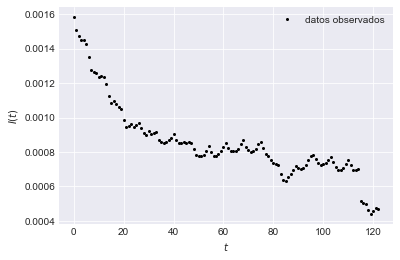

In [20]:
# Plot observations and true data
plt.plot(filtered_df_p1['Casos activos confirmados'], marker="o", linestyle="none", color='k', markersize=2, label=f"datos observados")
plt.xlabel("$t$")
plt.ylabel("$I(t)$")
plt.legend()
plt.show()

In [21]:
#seed(14092022)

In [22]:
# NOTA: fijar el seed SOLAMENTE si se estan probando diferentes modelos
# seed(2418)

# From now on we'll work with proportions instead of integer numbers
# i -> infectados/N
# Parameters: 
# beta = disease transmission rate
# gamma = recovery rate
# mu = mortality rate
# mu + beta = renewal rate
# theta = [beta - (mu+gamma), beta]
# Thus, if theta[0]<0, the disease will vanish and if theta[0]>0 we have persistence of the disease

i0 = filtered_df_p1['Casos activos confirmados'][0] #0.2 # initial proportion of infected
Tf = len(filtered_df_p1['Casos activos confirmados']) #20  # Terminal time
T0 = 0 # Initial time
Dt = 1 # time step

times = np.arange(T0, Tf, Dt) # time vector

In [23]:
# ODE model
def SIS(i, t, theta):
    di = theta[0]* i[0] - theta[1]* i[0]*i[0]
    return di

In [24]:
sis_model = DifferentialEquation(
    func=SIS,
    times = np.arange(T0, Tf, Dt),
    n_states=1,
    n_theta=2,
    t0=0,
)

In [25]:
# ODE solution (analytical solution computed before)
def solution_SIS(t,*param):
  aux_exp = np.exp(param[0]*t)
  aux = param[0] + param[1]*(i0)*(aux_exp - 1)
  return i0*param[0]*aux_exp/aux

In [26]:
infected_obs_1=np.array(filtered_df_p1['Casos activos confirmados'])

In [27]:
infected_obs = np.array([[values] for values in infected_obs_1 ])

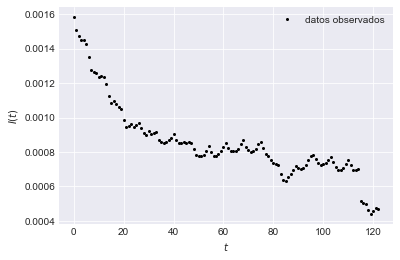

In [28]:
# Plot observations and true data
plt.plot(times, infected_obs, marker="o", linestyle="none", color='k', markersize=2, label=f"datos observados")
plt.xlabel("$t$")
plt.ylabel("$I(t)$")
plt.legend()
plt.show()

In [29]:
# REGRESION MODEL -------------------------------------------------------------
# This suppose to be our benchmark in the case of the deterministic model
theta0 = np.asarray([0.1, 0.1])#punto de partida para la busqueda del optimo
reg_estim, _ = opt.curve_fit(solution_SIS, xdata = times, p0=theta0, ydata = infected_obs.flatten(), maxfev=5000)     
print("\n Parámetros estimados con regresión", reg_estim)
reg_model = solution_SIS(times, *reg_estim) # curve obtained from regresion estimates


 Parámetros estimados con regresión [2.11145297e-02 3.29017053e+01]


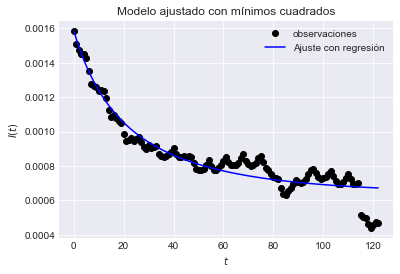

In [30]:
# COMPARE REGRESION MODEL VERSUS TRUE MODEL AND OBSERVATIONS-------------------
plt.plot(times, infected_obs.flatten(), "ko", label="observaciones")
plt.plot(times, reg_model, "b-", label="Ajuste con regresión")
plt.xlabel("$t$")
plt.ylabel("$I(t)$")
plt.title("Modelo ajustado con mínimos cuadrados")
plt.legend(loc="upper right")
plt.show()

In [31]:
# Define pymc model and sampling the MC Markov chain
nb_chains = 2 #choose >1 to run some convergence diagnostics on the chains
len_chains = 3000
len_burning_states = 1000

In [32]:
with pm.Model() as model4:
    # Define prior distributions
    noise_hiperparam = pm.HalfCauchy("noise_hiperparam", 1, shape=1) # noise hiperparameter
    # This prior does not assume a prior knowledge on the persistence or extintion of the disease
    # But if the user knows if the disease persists, the prior can be feed with more info on the support
    param = [0,0]
    param[0] = pm.Normal("beta-(mu+gamma)",0,1) 
    param[1] = pm.Bound(pm.Cauchy, lower=0)("beta", 1,2)
    # define output of the computational model
    sis_curves = sis_model(y0=[i0], theta=param)
    #Define statistical model for observations
    Y = pm.Lognormal("Y", mu=pm.math.log(sis_curves), sigma=noise_hiperparam, observed=infected_obs)
    trace = pm.sample(len_chains, tune=len_burning_states, cores=1, chains=nb_chains)
    data = az.from_pymc3(trace=trace)

C:\Users\sebas\AppData\Local\Temp\ipykernel_23140\3905185759.py:13: FutureWarning:

In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta, beta-(mu+gamma), noise_hiperparam]


c:\Users\sebas\anaconda3\envs\pymc_env\lib\site-packages\scipy\integrate\odepack.py:247: ODEintWarning:

Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.



Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 2167 seconds.


WARN: Could not locate executable g77
WARN: Could not locate executable f77
WARN: Could not locate executable ifort
WARN: Could not locate executable ifl
WARN: Could not locate executable f90
WARN: Could not locate executable DF
WARN: Could not locate executable efl


In [33]:
# CONVERGENCE DIAGNOSTICS -----------------------------------------------------
print("\n Resumen de los resultados para la cadena de Markov construida:")
az.summary(trace)

Got error No model on context stack. trying to find log_likelihood in translation.



 Resumen de los resultados para la cadena de Markov construida:


c:\Users\sebas\anaconda3\envs\pymc_env\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning:

Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.



,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta-(mu+gamma),0.017,0.002,0.012,0.021,0.000,0.000,1917.0,1902.0,1.0
noise_hiperparam[0],0.107,0.007,0.095,0.121,0.000,0.000,2397.0,2372.0,1.0
beta,27.825,2.857,22.501,32.878,0.065,0.046,1930.0,2075.0,1.0


Text(0, 0.5, 'MCMC promedio')

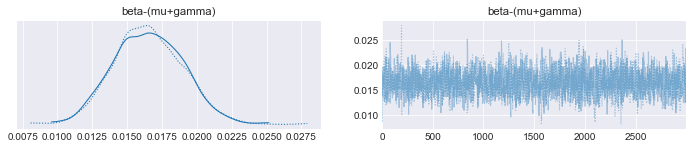

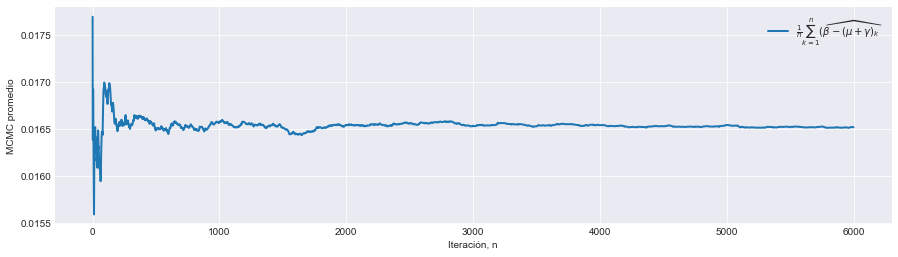

In [34]:
# plot the exploration for each chain and convergence of the ergodic mean
# beta - (mu+gamma)
az.plot_trace({"beta-(mu+gamma)": trace.get_values(varname="beta-(mu+gamma)", combine=False)})
mean_theta0 = [np.mean(trace['beta-(mu+gamma)'][:i]) for i in np.arange(1, len(trace['beta-(mu+gamma)']))]
plt.figure(figsize=(15, 4))
plt.plot(mean_theta0, lw=2, label=r"$\frac{1}{n}\sum_{k=1}^n\widehat{(\beta-(\mu+\gamma)}_k$")
plt.xlabel("Iteración, n")
plt.legend()
plt.ylabel("MCMC promedio")

Text(0, 0.5, 'MCMC promedio')

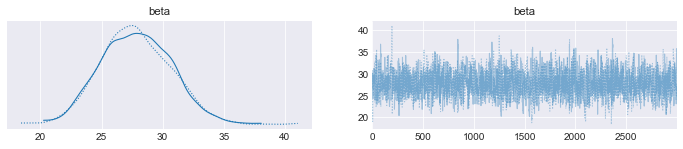

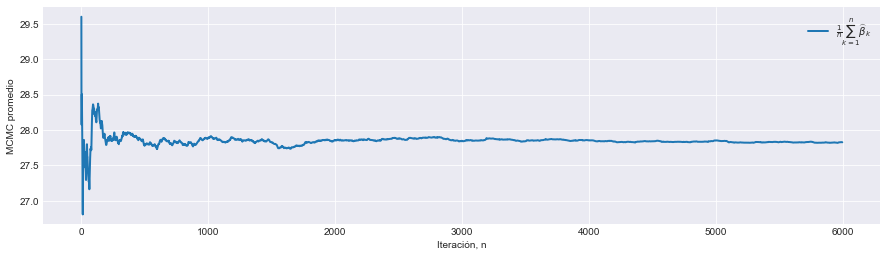

In [35]:
# beta
az.plot_trace({"beta": trace.get_values(varname="beta", combine=False)})
mean_theta1 = [np.mean(trace['beta'][:i]) for i in np.arange(1, len(trace['beta']))]
plt.figure(figsize=(15, 4))
plt.plot(mean_theta1, lw=2, label=r"$\frac{1}{n}\sum_{k=1}^n\widehat{\beta}_k$")
plt.xlabel("Iteración, n")
plt.legend()
plt.ylabel("MCMC promedio")

In [36]:
# Define bayes model with Bayes estimators
MCMC_model = solution_SIS(times, mean_theta0[-1], mean_theta1[-1])

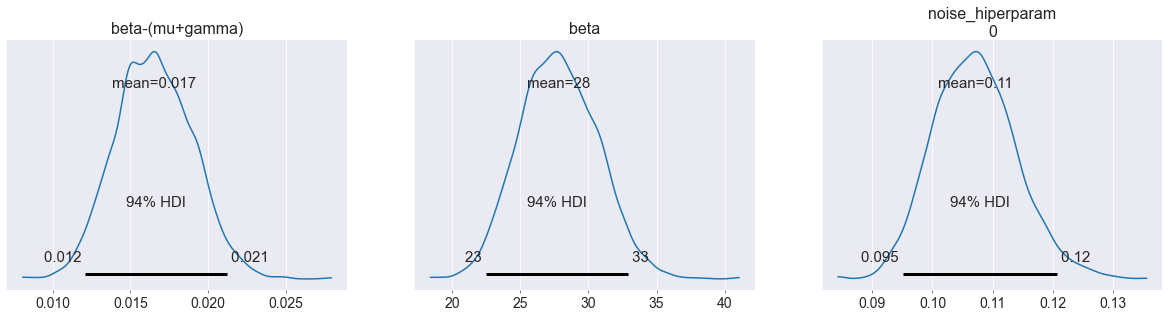

In [37]:
# Plot posterior densities
az.plot_posterior(data, 
                  var_names=["beta-(mu+gamma)", "beta", "noise_hiperparam"]);
plt.show()

In [38]:
# VALIDATION OF PYMC MODEL----------------------------------------------------    
print("Parámetros estimados con regresión:", reg_estim)
print("Parámetros estimados con MCMC:", [mean_theta0[-1], mean_theta1[-1]])

Parámetros estimados con regresión: [2.11145297e-02 3.29017053e+01]
Parámetros estimados con MCMC: [0.016515239544483157, 27.825620003018756]


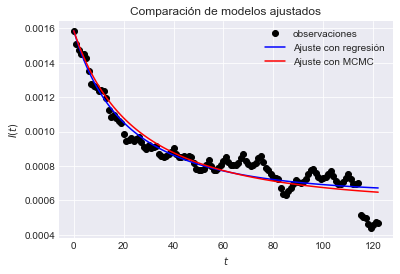

In [39]:
# COMPARE MODELS -------------------
plt.plot(times, infected_obs.flatten(), "ko", label="observaciones")
plt.plot(times, reg_model, "b-", label="Ajuste con regresión")
plt.plot(times, MCMC_model, "r-", label="Ajuste con MCMC")
plt.xlabel("$t$")
plt.ylabel("$I(t)$")
plt.title("Comparación de modelos ajustados")
plt.legend(loc="upper right")
plt.show()


In [40]:
#MSE with respect to observed data
print("\n Error cuadrático medio para regresión:",mean_squared_error(infected_obs, reg_model))
print("Error cuadrático medio para MCMC:",mean_squared_error(infected_obs, MCMC_model))


 Error cuadrático medio para regresión: 4.662571081825191e-09
Error cuadrático medio para MCMC: 4.920763782641247e-09


In [46]:
with model4:
    ppc = pm.sample_posterior_predictive(trace,samples=10000)

<AxesSubplot:xlabel='Y / Y'>

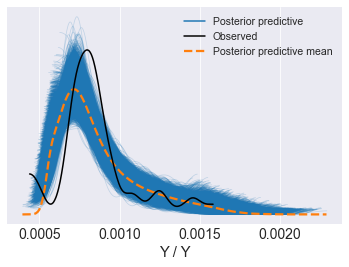

In [47]:
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=model4))

In [48]:
az.summary(ppc)

c:\Users\sebas\anaconda3\envs\pymc_env\lib\site-packages\arviz\data\base.py:220: UserWarning:

More chains (10000) than draws (123). Passed array should have shape (chains, draws, *shape)



,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Y[0],0.001,0.0,0.001,0.001,0.0,0.0,20641.0,176540.0,1.43


c:\Users\sebas\anaconda3\envs\pymc_env\lib\site-packages\arviz\data\base.py:220: UserWarning:

More chains (10000) than draws (123). Passed array should have shape (chains, draws, *shape)



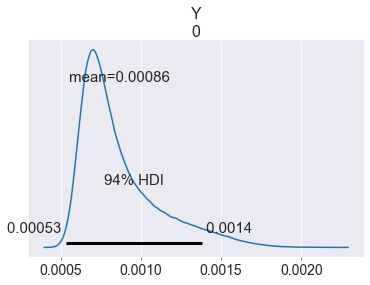

In [49]:
az.plot_posterior(ppc);
plt.show()